In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import figures as f

#import os
#os.environ['pRT_input_data_path'] = '/home/sdregt/new_retrieval_venv/pRT_input_data'
#os.environ['LD_LIBRARY_PATH'] = '/home/sdregt/new_retrieval_venv/MultiNest/lib'

import retrieval_base.auxiliary_functions as af
import pymultinest
import json
import copy

from tqdm import tqdm

import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d

In [2]:

def read_results(prefix, n_params, m_set='K2166_cloudy', w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()
    ln_Z = stats['nested importance sampling global log-evidence']

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+f'data/bestfit_PT_{m_set}.pkl')
    Chem = af.pickle_load(prefix+f'data/bestfit_Chem_{m_set}.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{m_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{m_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{m_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{m_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{m_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{m_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    return ln_Z, posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

#prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_4/test_'
#prefix_no_band = './retrieval_outputs/no_bands_K_A_ret_1/test_'
prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_5/test_'
res = read_results(prefix=prefix_no_band, n_params=26)
ln_Z_no_band, _, _, _, _, _, _, _, m_spec_no_band, d_spec, LogLike_no_band, Cov_no_band, bestfit_params_no_band = res
del res

#prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_1/test_'
#prefix_eq_band = './retrieval_outputs/eq_band_K_A_ret_2/test_'
prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_2/test_'
res = read_results(prefix=prefix_eq_band, n_params=28)
ln_Z_eq_band, _, _, _, _, _, _, _, m_spec_eq_band, d_spec, LogLike_eq_band, Cov_eq_band, bestfit_params_eq_band = res
del res

  analysing data from ./retrieval_outputs/no_bands_K_B_ret_5/test_.txt
  analysing data from ./retrieval_outputs/eq_band_K_B_ret_2/test_.txt


0.028999999999999998 0.563
0.5371999999999999 0.5888


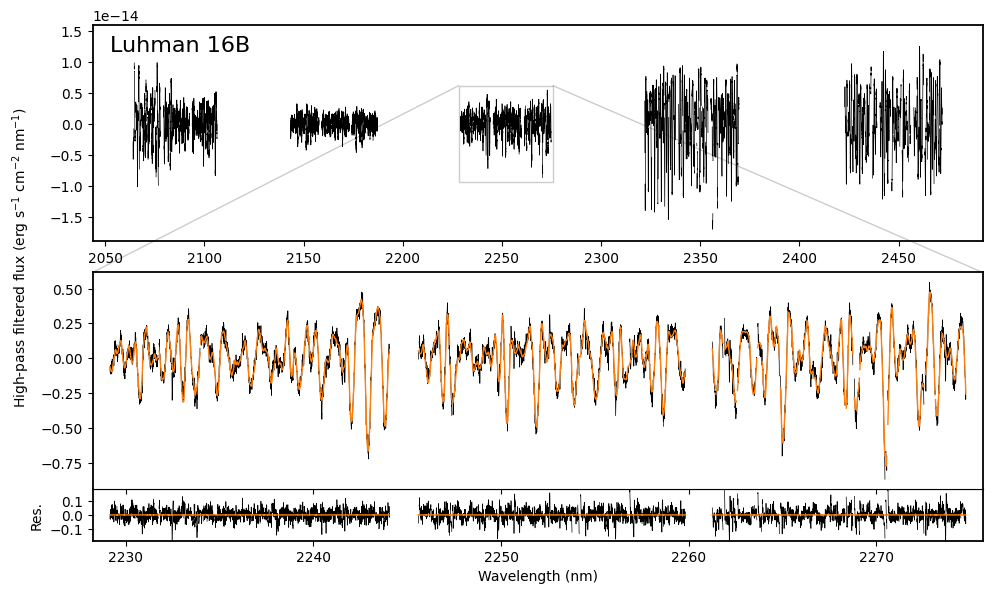

In [177]:
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(nrows=4, ncols=1, hspace=0, wspace=0.02, height_ratios=[0.42,0.06,0.42,0.1])

ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[2,0]), 
    fig.add_subplot(gs[3,0])
    ])

scale = 1e14

for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        ax[0].plot(d_spec.wave[i,j], d_spec.flux[i,j], c='k', lw=0.5)
        #ax[0].plot(d_spec.wave[i,j], LogLike_eq_band.m_flux_phi[i,j], c='C1', lw=1.5)

        if i == 2:
            ax[1].plot(d_spec.wave[i,j], scale*(d_spec.flux[i,j]), c='k', lw=0.5)
            ax[1].plot(d_spec.wave[i,j], scale*(LogLike_eq_band.m_flux_phi[i,j]), c='C1', lw=1)

            ax[2].plot(d_spec.wave[i,j], scale*(d_spec.flux[i,j]-LogLike_eq_band.m_flux_phi[i,j]), c='k', lw=0.5)
            ax[2].plot(d_spec.wave[i,j], scale*(LogLike_eq_band.m_flux_phi[i,j]-LogLike_eq_band.m_flux_phi[i,j]), c='C1', lw=1)

            #ax[1].plot(d_spec.wave[i,j], scale*(LogLike_no_band.m_flux_phi[i,j]), c='C2', lw=1)
            #ax[2].plot(d_spec.wave[i,j], scale*(LogLike_no_band.m_flux_phi[i,j]-LogLike_eq_band.m_flux_phi[i,j]), c='C2', lw=1)

            ax[1].set(xlim=(d_spec.wave[i,:].min()-0.7, d_spec.wave[i,:].max()+0.7))
            ax[2].set(xlim=ax[1].get_xlim())

#ax[0].set(ylabel='High-pass filtered flux '+r'$\mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$')
#ax[1].set(ylim=ax[0].get_ylim)
ax[0].annotate(
    'Luhman 16B', xy=(0.02,0.95), xycoords='axes fraction', ha='left', va='top', fontsize=16
    )
ax[0].set(ylim=(-1.9e-14,1.6e-14))
ax[1].set(xticklabels=[])
ax[2].set(xlabel=r'Wavelength (nm)', ylabel='Res.')

x0 = ax[1].get_xlim()[0]
y0 = ax[1].get_ylim()[0]/scale
width  = np.abs(ax[1].get_xlim()[1] - x0)
height = np.abs(ax[1].get_ylim()[1]/scale - y0)
bounds = (x0, y0, width, height)

_, con_patch = ax[0].indicate_inset(
    bounds=bounds, inset_ax=ax[1], edgecolor='k', alpha=0.2, 
    )

height_ratio = gs.get_height_ratios()[3] / gs.get_height_ratios()[2]
ax[2].set_ylim(-0.5*height_ratio*height*scale, +0.5*height_ratio*height*scale)
#print(np.diff(ax[2].get_ylim())/np.diff(ax[1].get_ylim()), 0.1/0.42)

spine_lw = 1.3
ax[0].spines[['left','right','top','bottom']].set_linewidth(spine_lw)
ax[1].spines[['left','right','top']].set_linewidth(spine_lw)
ax[2].spines[['left','right','bottom']].set_linewidth(spine_lw)
ax[2].set_zorder(-2)

plt.subplots_adjust(left=0.09, bottom=0.09, top=0.95, right=0.98)

l0, b0, w0, h0 = ax[0].get_position().bounds
l1, b1, w1, h1 = ax[1].get_position().bounds

x0 = l0 - 0.061
y0 = np.mean([b1+h1, b0])
print(x0, y0)
print(b1+h1, b0)

fig.text(
    x0, y0, 'High-pass filtered flux '+r'$\mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', 
    rotation=90, ha='right', va='center', #transform=fig.transFigure
    )

plt.savefig('./plots/banded_cloud_spec_B.pdf')
plt.show()